# Data Mining - Predict Emotion

###  Dataset description “Dataset_Study2”:
    The dataset in attachment contains some features extracted by processing physiological responses of 186 healthy subjects. The aim of the study was measuring cardiovascular, respiratory, and electrodermal responses to positive stimuli that differed in approach intensity. Specifically, this study examined how high approach and low approach positive emotions buffer stress responses. Also, it was examined whether reactivity to anger (a high approach negative emotion) vs. threat would interact with high approach positive affect. 

#### Labels
  o   Baseline condition = -1

  o   Threat = 209

  o   Anger = 208

  o   Low-approach positive emotions = 308

  o   High-approach positive emotions = 309

  o   Neutral State = 108.

## 1) Libraries Import

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from scipy.stats import zscore
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

## 2) Load the dataframe

In [2]:
# Load the dataset
df = pd.read_csv('Dataset_Study2.csv')


In [3]:
# Displaying the first few rows of the dataset
df.head()

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_HTI,HRV_VLF,HRV_LF,HRV_HF,HRV_TP,HRV_LFHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_DFA_alpha1,HRV_DFA_alpha2,HRV_ApEn,HRV_SampEn,Label
0,633.550847,38.041925,19.616881,604.0,659.6,1.902748,8.600000,25.527837,267.064034,220.060097,518.379141,1.213596,13.885877,52.017745,0.266945,1.360608,0.944455,1.127490,1.220454,-1
1,634.294326,34.905271,19.514863,606.0,661.0,1.060071,9.433333,34.571328,202.020945,299.724501,544.735363,0.674022,13.823506,47.460479,0.291264,1.116241,1.047786,1.015512,1.346990,208
2,654.307692,32.554950,20.624986,628.6,676.0,1.824818,7.210526,18.540159,194.006336,232.471059,449.074241,0.834540,14.610221,43.633562,0.334839,1.066257,1.115793,1.116038,1.559592,308
3,683.329519,37.113918,20.695118,652.0,713.0,2.054795,9.954545,30.059410,784.401196,183.196502,1007.048017,4.281748,14.650400,50.455899,0.290360,1.519910,0.717760,1.229202,1.475701,-1
4,666.906367,36.170562,19.314110,636.4,694.6,1.492537,10.307692,61.690354,494.702147,118.019442,681.887789,4.191700,13.682454,49.339452,0.277313,1.440717,0.795543,1.073102,1.387314,208


In [4]:
# Displaying the shape of the dataset (number of rows and columns)
df.shape

(558, 20)

In [5]:
#dataset contains 558 rows and 20 columns

### Check for Missing Values and Data Types

In [6]:
# Displaying information about the dataset to understand data types and check for missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HRV_MeanNN      558 non-null    float64
 1   HRV_SDNN        558 non-null    float64
 2   HRV_RMSSD       558 non-null    float64
 3   HRV_Prc20NN     558 non-null    float64
 4   HRV_Prc80NN     558 non-null    float64
 5   HRV_pNN50       558 non-null    float64
 6   HRV_HTI         558 non-null    float64
 7   HRV_VLF         558 non-null    float64
 8   HRV_LF          558 non-null    float64
 9   HRV_HF          558 non-null    float64
 10  HRV_TP          558 non-null    float64
 11  HRV_LFHF        558 non-null    float64
 12  HRV_SD1         558 non-null    float64
 13  HRV_SD2         558 non-null    float64
 14  HRV_SD1SD2      558 non-null    float64
 15  HRV_DFA_alpha1  558 non-null    float64
 16  HRV_DFA_alpha2  558 non-null    float64
 17  HRV_ApEn        558 non-null    flo

***
Summary:
- The dataset contains 558 rows and 20 columns.
- There are no missing data.
- Data includes two types: int64 (Label) and float64 (for 19 features).
***

## 3) Data Preprocessing

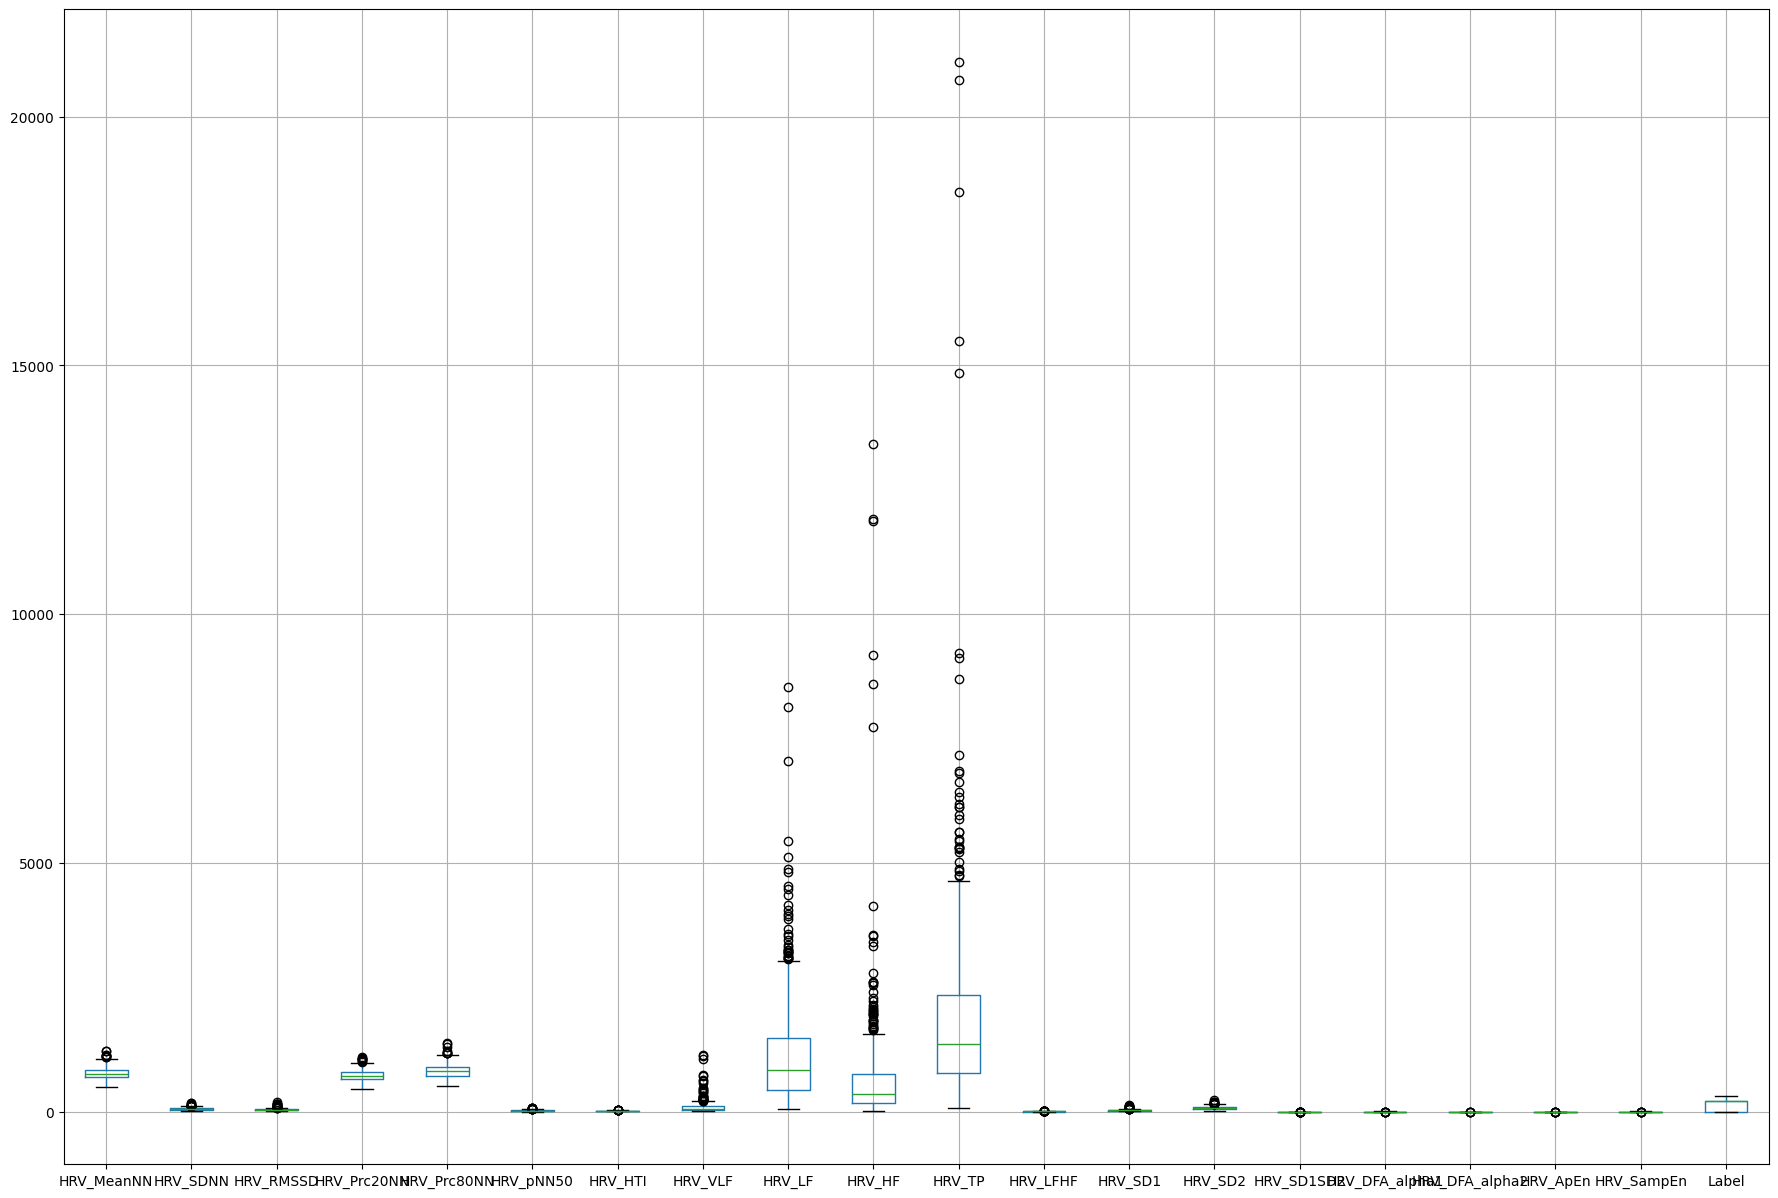

In [7]:
# Plotting boxplots to identify potential outliers in the dataset
df.boxplot(figsize=(22,15))
plt.show()

### Handling Outliers

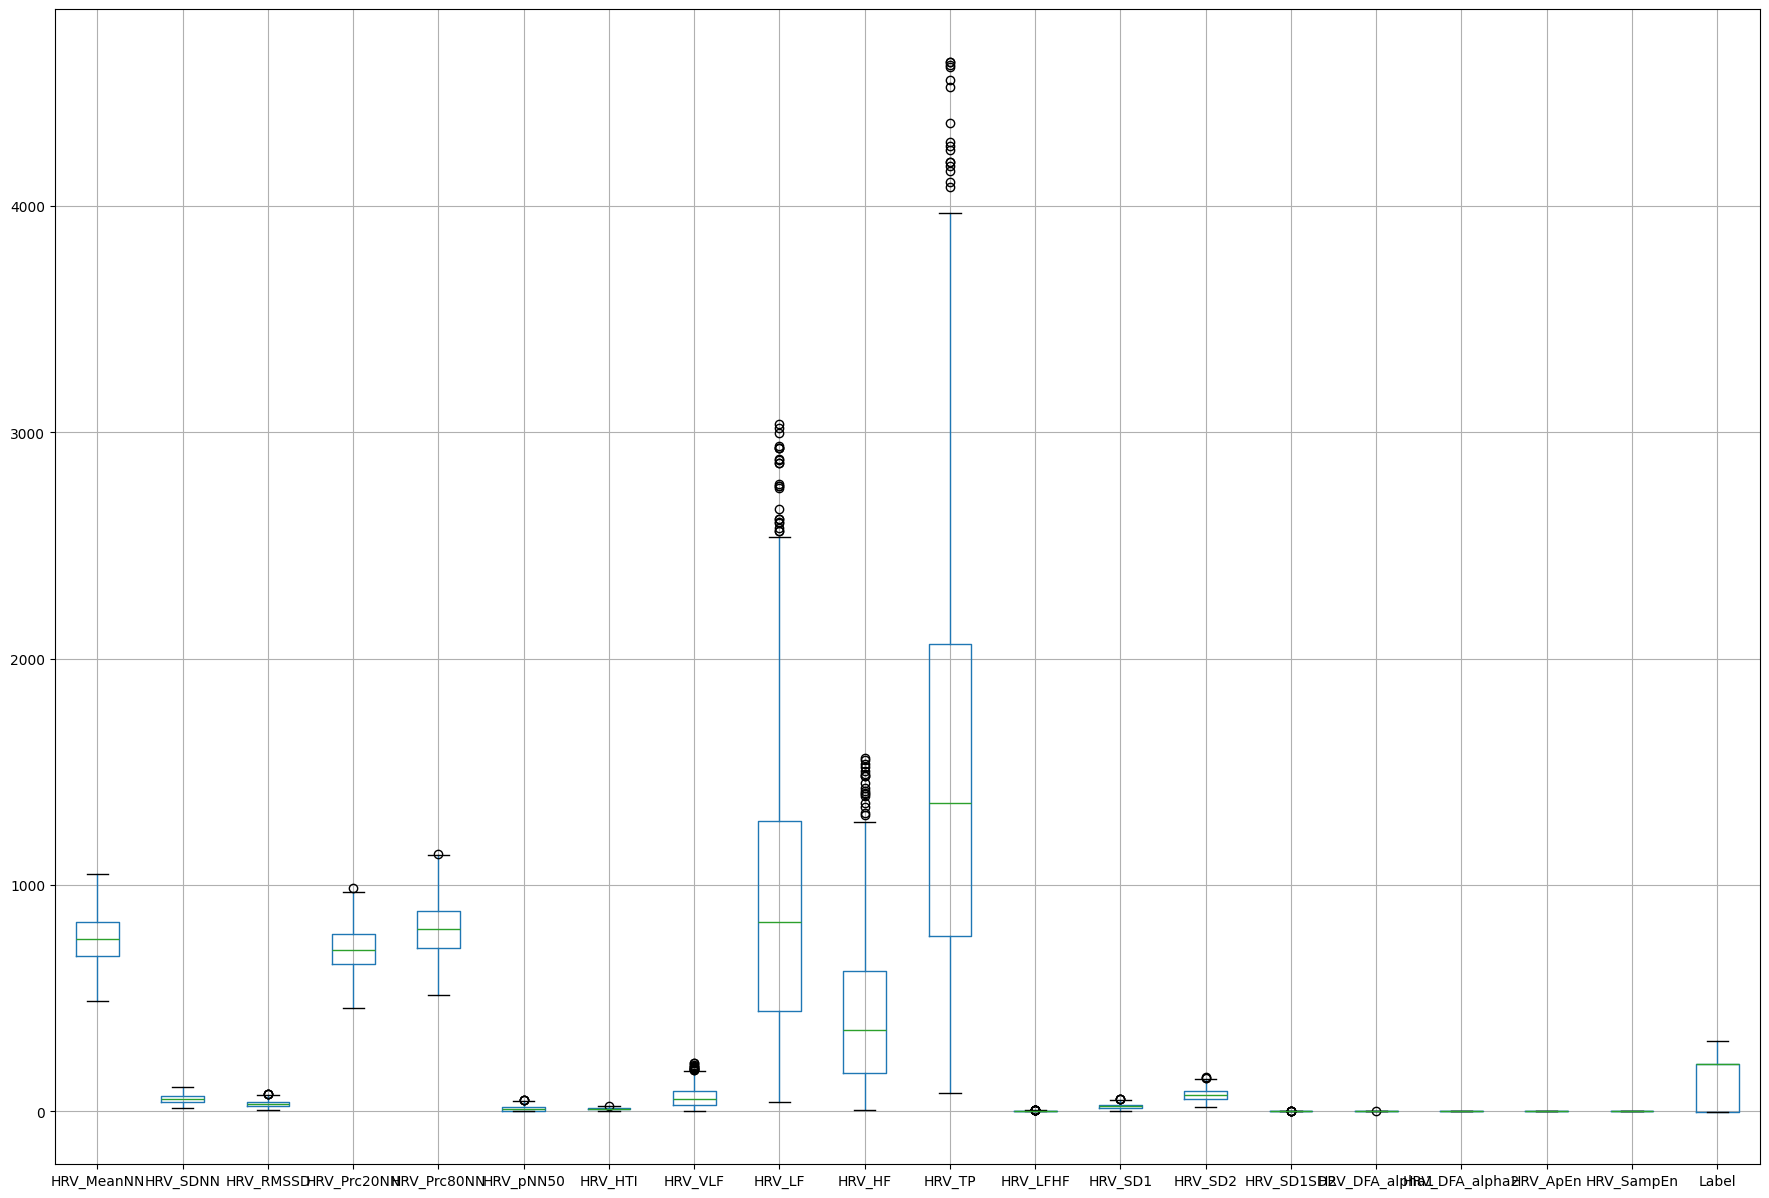

In [8]:
# Replace outliers with the median values

def replace_outliers_with_median(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace outliers with median
    for column in df.columns:
        median = df[column].median()
        df[column] = np.where((df[column] < lower_bound[column]) | (df[column] > upper_bound[column]), 
                              median, 
                              df[column])
    
    return df

# Replacing outliers with median
df = replace_outliers_with_median(df)

# Display boxplot to see the data after outlier replacement
plt.figure(figsize=(22, 15))
df.boxplot()
plt.show()


### Addressing Zero Values in HRV Measurements

In [9]:
# Addressing Zero values
from sklearn.impute import SimpleImputer

# Replacing 0 values with NaN in columns where 0 is not realistic
columns_with_zeros = ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_Prc20NN', 'HRV_Prc80NN', 'HRV_pNN50', 'HRV_HTI', 'HRV_VLF', 'HRV_LF', 'HRV_HF', 'HRV_TP', 'HRV_LFHF', 'HRV_SD1', 'HRV_SD2', 'HRV_SD1SD2', 'HRV_DFA_alpha1', 'HRV_DFA_alpha2', 'HRV_ApEn', 'HRV_SampEn']
df[columns_with_zeros] = df[columns_with_zeros].replace(0, np.nan)
# biologically implausible for these measurements. These zero values may indicate missing or unrecorded data.
#We'll replace them with the median of their respective columns.

# Imputing the missing values using median
imputer = SimpleImputer(strategy='median')
df[columns_with_zeros] = imputer.fit_transform(df[columns_with_zeros])

# Display the first few rows after imputation
df.head()

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_HTI,HRV_VLF,HRV_LF,HRV_HF,HRV_TP,HRV_LFHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_DFA_alpha1,HRV_DFA_alpha2,HRV_ApEn,HRV_SampEn,Label
0,633.550847,38.041925,19.616881,604.0,659.6,1.902748,8.600000,25.527837,267.064034,220.060097,518.379141,1.213596,13.885877,52.017745,0.266945,1.360608,0.944455,1.127490,1.220454,-1.0
1,634.294326,34.905271,19.514863,606.0,661.0,1.060071,9.433333,34.571328,202.020945,299.724501,544.735363,0.674022,13.823506,47.460479,0.291264,1.116241,1.047786,1.015512,1.346990,208.0
2,654.307692,32.554950,20.624986,628.6,676.0,1.824818,7.210526,18.540159,194.006336,232.471059,449.074241,0.834540,14.610221,43.633562,0.334839,1.066257,1.115793,1.116038,1.559592,308.0
3,683.329519,37.113918,20.695118,652.0,713.0,2.054795,9.954545,30.059410,784.401196,183.196502,1007.048017,4.281748,14.650400,50.455899,0.290360,1.519910,0.717760,1.229202,1.475701,-1.0
4,666.906367,36.170562,19.314110,636.4,694.6,1.492537,10.307692,61.690354,494.702147,118.019442,681.887789,4.191700,13.682454,49.339452,0.277313,1.440717,0.795543,1.073102,1.387314,208.0


### Check for negative values in all columns except the target variable

In [10]:
columns_to_check = df.columns[df.columns != 'Label']
negative_values_mask = df[columns_to_check] < 0

# Filter rows containing negative values in columns (excluding the target variable)
rows_with_negative_values = df[negative_values_mask.any(axis=1)]

# Display rows with negative values in columns (excluding the target variable)
print("Rows containing negative values in columns (excluding the 'Label' column):")
print(rows_with_negative_values)

Rows containing negative values in columns (excluding the 'Label' column):
Empty DataFrame
Columns: [HRV_MeanNN, HRV_SDNN, HRV_RMSSD, HRV_Prc20NN, HRV_Prc80NN, HRV_pNN50, HRV_HTI, HRV_VLF, HRV_LF, HRV_HF, HRV_TP, HRV_LFHF, HRV_SD1, HRV_SD2, HRV_SD1SD2, HRV_DFA_alpha1, HRV_DFA_alpha2, HRV_ApEn, HRV_SampEn, Label]
Index: []


***no negative values***

In [11]:
# Displaying the shape of the dataset to confirm the size
df.shape


(558, 20)

### Encode the Labels

In [12]:
# Mapping dictionary for labels
label_mapping = {
    -1: 0,
    209: 3,
    208: 2,
    308: 4,
    309: 5,
    108: 1
}

# Apply mapping
df['Label'] = df['Label'].map(label_mapping)

In [13]:
# Displaying information about the dataset after label mapping
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558 entries, 0 to 557
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   HRV_MeanNN      558 non-null    float64
 1   HRV_SDNN        558 non-null    float64
 2   HRV_RMSSD       558 non-null    float64
 3   HRV_Prc20NN     558 non-null    float64
 4   HRV_Prc80NN     558 non-null    float64
 5   HRV_pNN50       558 non-null    float64
 6   HRV_HTI         558 non-null    float64
 7   HRV_VLF         558 non-null    float64
 8   HRV_LF          558 non-null    float64
 9   HRV_HF          558 non-null    float64
 10  HRV_TP          558 non-null    float64
 11  HRV_LFHF        558 non-null    float64
 12  HRV_SD1         558 non-null    float64
 13  HRV_SD2         558 non-null    float64
 14  HRV_SD1SD2      558 non-null    float64
 15  HRV_DFA_alpha1  558 non-null    float64
 16  HRV_DFA_alpha2  558 non-null    float64
 17  HRV_ApEn        558 non-null    flo

In [14]:
# Displaying the first few rows to verify the label mapping
df.head()

,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_HTI,HRV_VLF,HRV_LF,HRV_HF,HRV_TP,HRV_LFHF,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_DFA_alpha1,HRV_DFA_alpha2,HRV_ApEn,HRV_SampEn,Label
0,633.550847,38.041925,19.616881,604.0,659.6,1.902748,8.600000,25.527837,267.064034,220.060097,518.379141,1.213596,13.885877,52.017745,0.266945,1.360608,0.944455,1.127490,1.220454,0
1,634.294326,34.905271,19.514863,606.0,661.0,1.060071,9.433333,34.571328,202.020945,299.724501,544.735363,0.674022,13.823506,47.460479,0.291264,1.116241,1.047786,1.015512,1.346990,2
2,654.307692,32.554950,20.624986,628.6,676.0,1.824818,7.210526,18.540159,194.006336,232.471059,449.074241,0.834540,14.610221,43.633562,0.334839,1.066257,1.115793,1.116038,1.559592,4
3,683.329519,37.113918,20.695118,652.0,713.0,2.054795,9.954545,30.059410,784.401196,183.196502,1007.048017,4.281748,14.650400,50.455899,0.290360,1.519910,0.717760,1.229202,1.475701,0
4,666.906367,36.170562,19.314110,636.4,694.6,1.492537,10.307692,61.690354,494.702147,118.019442,681.887789,4.191700,13.682454,49.339452,0.277313,1.440717,0.795543,1.073102,1.387314,2


## 4) Data Exploration

## Correlation

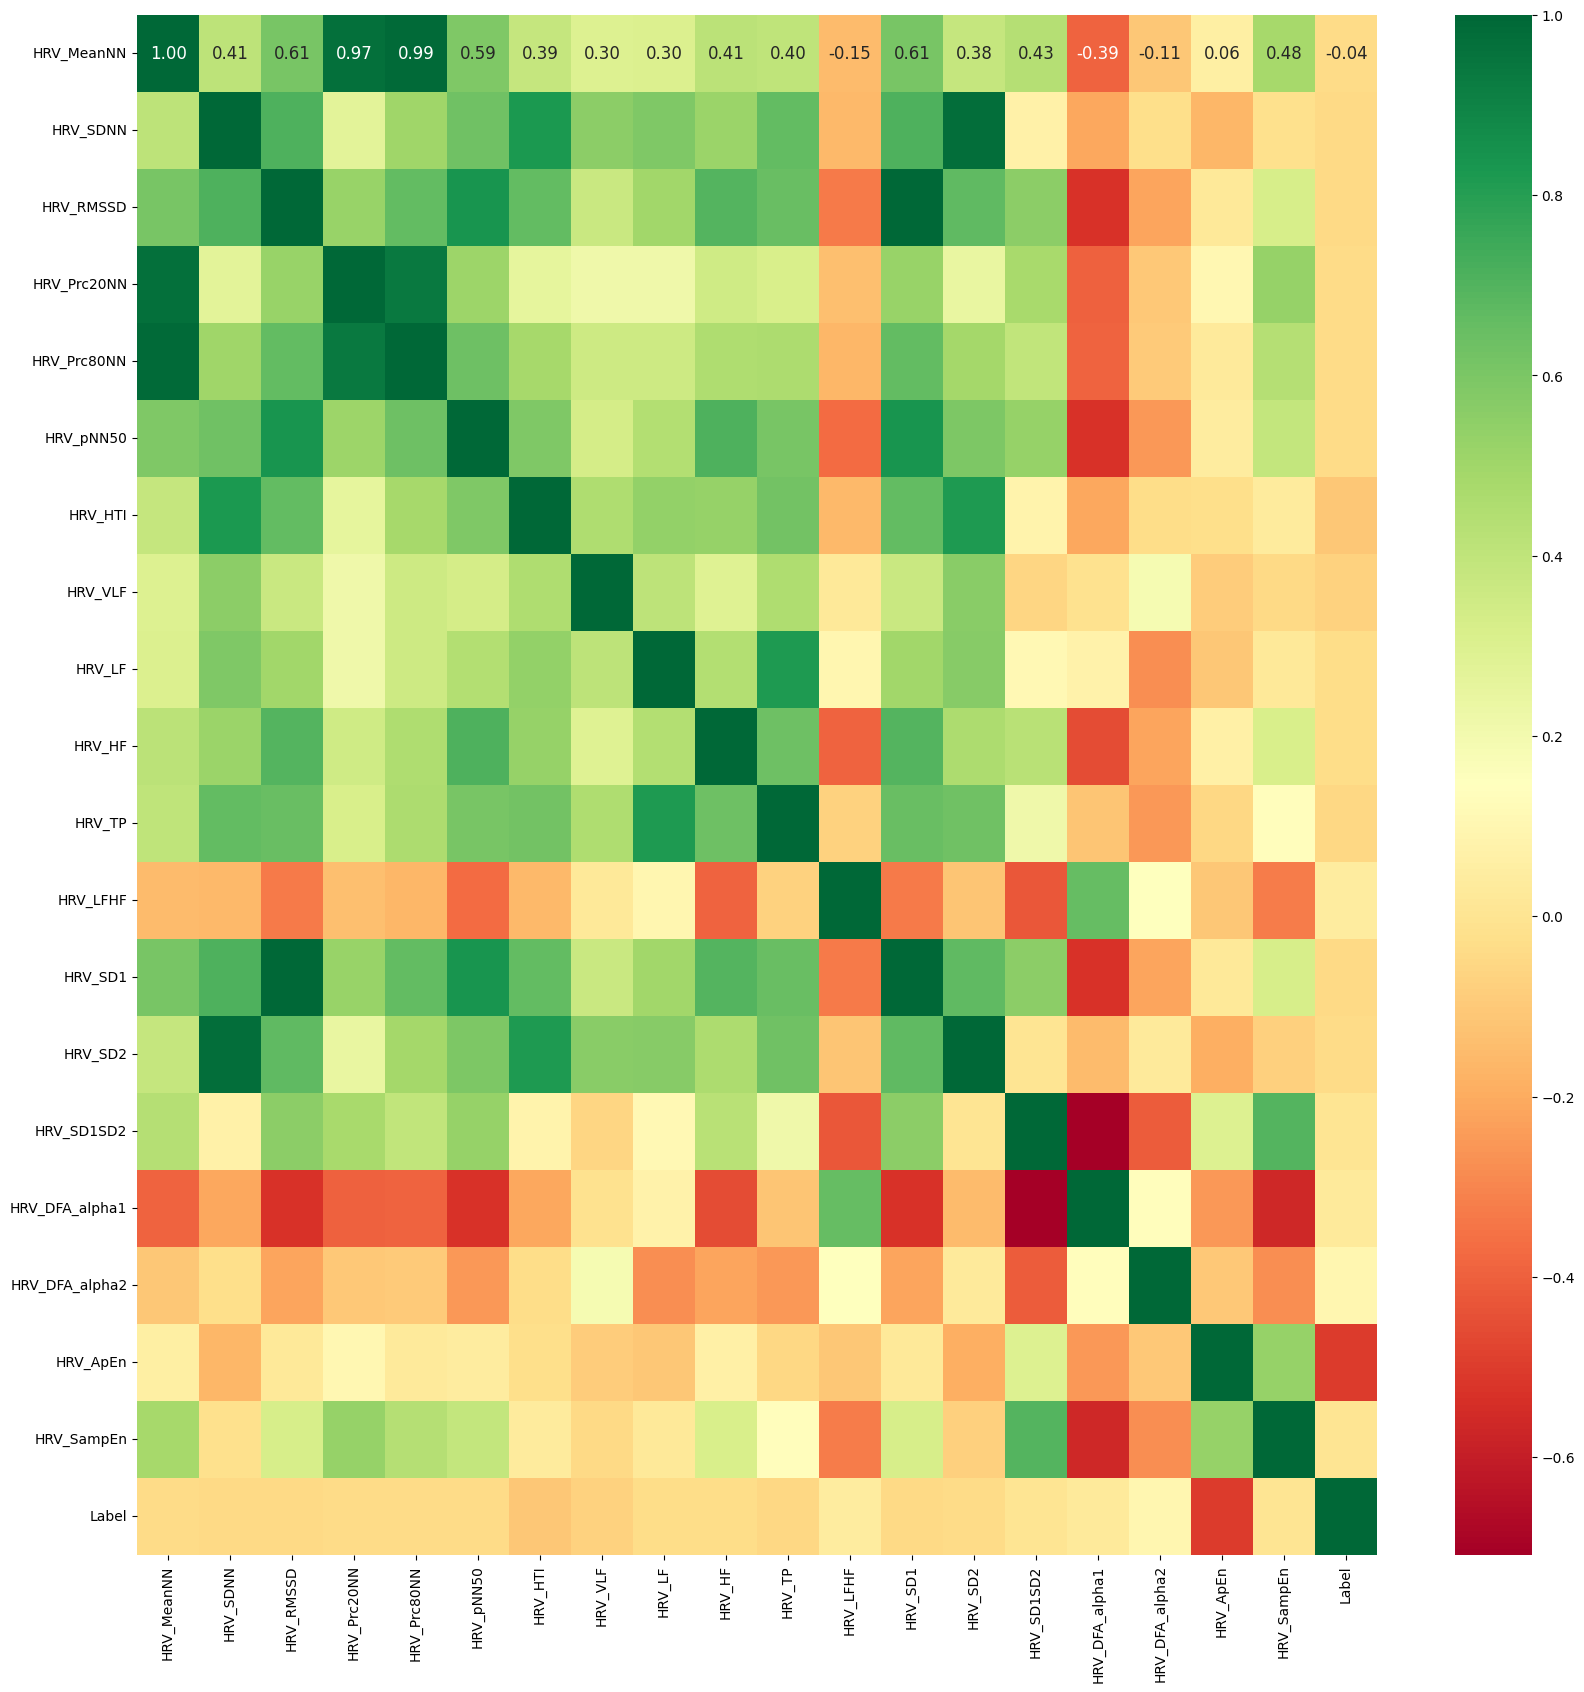

In [15]:
# Generating a correlation matrix to understand relationships between features
corrmat = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat, annot=True, cmap="RdYlGn", fmt=".2f", annot_kws={"size": 12})
plt.show()

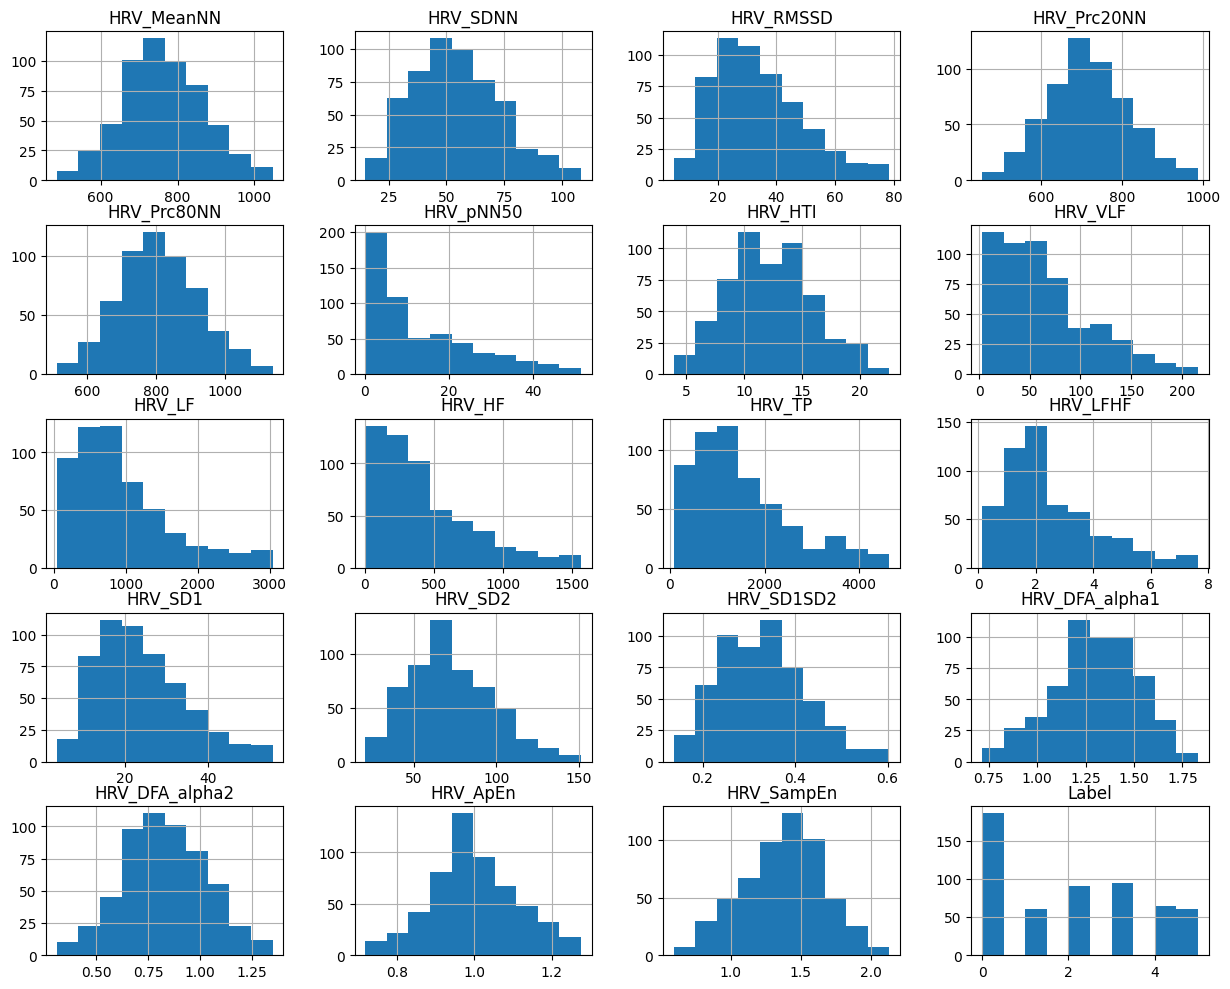

In [16]:
# Plotting histograms to visualize the distribution of features
df.hist(figsize = (15,12))
plt.show()

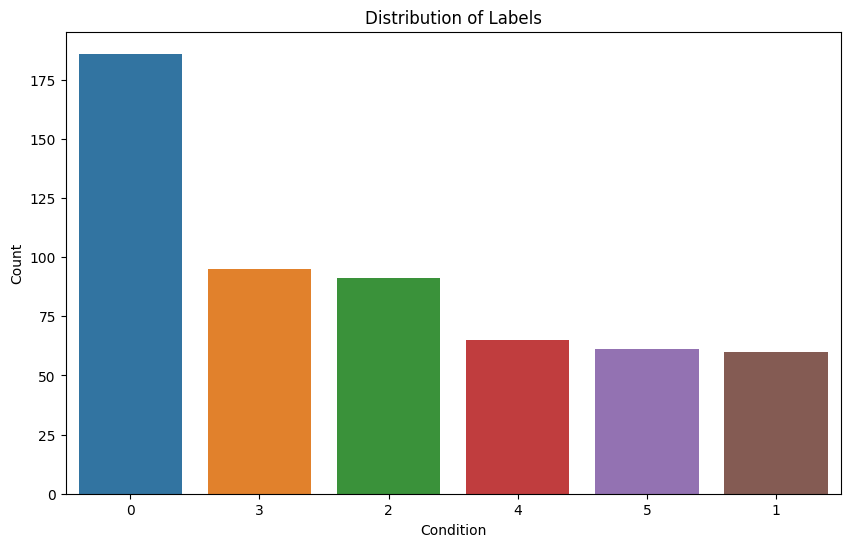

(        HRV_MeanNN    HRV_SDNN   HRV_RMSSD  HRV_Prc20NN  HRV_Prc80NN  \
 count   558.000000  558.000000  558.000000   558.000000   558.000000   
 mean    762.709852   54.393986   33.898946   716.825090   807.684229   
 std     105.727797   19.046097   14.991547    99.252856   116.116232   
 min     486.051630   14.932537    5.099882   456.000000   514.000000   
 25%     688.373552   40.815912   22.318062   649.400000   721.150000   
 50%     760.247137   53.084688   31.883178   714.250000   807.000000   
 75%     836.706847   68.025379   43.034902   783.150000   885.850000   
 max    1047.319298  108.118633   78.378151   986.400000  1136.000000   
 
         HRV_pNN50     HRV_HTI     HRV_VLF       HRV_LF       HRV_HF  \
 count  558.000000  558.000000  558.000000   558.000000   558.000000   
 mean    13.469155   12.257112   64.565042   952.197984   436.717022   
 std     12.515934    3.675705   45.921190   667.605466   350.437632   
 min      0.177620    3.917647    3.074690    42.7717

In [17]:
# Summary statistics
summary_stats = df.describe()

# Distribution of the label
label_distribution = df['Label'].value_counts()

# Plotting the distribution of labels
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df, order=label_distribution.index)
plt.title('Distribution of Labels')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

summary_stats, label_distribution

## Data Scaling 

In [18]:
# Split data into features and labels
X = df.drop('Label', axis=1)
y = df['Label']

In [19]:
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 5) Feature Selection

In [20]:
# Feature Selection using SelectKBest
select_kbest = SelectKBest(score_func=f_classif, k=10)
X_kbest = select_kbest.fit_transform(X_scaled, y)

## 6) PCA

In [21]:
#Apply PCA to reduce dimesionality

In [22]:
# Apply PCA and retain components explaining 95% of variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_kbest)

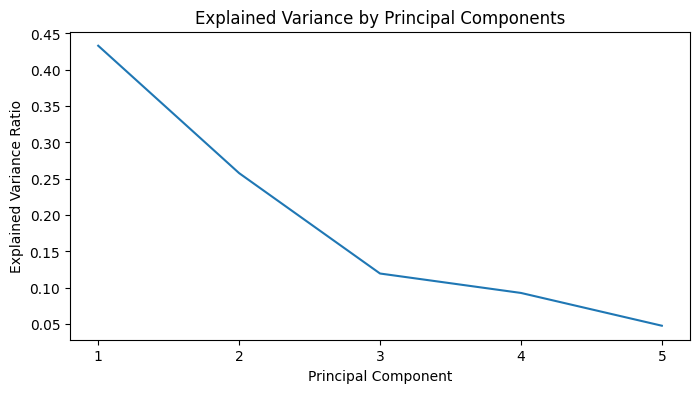

In [23]:
# Explained Variance Ratio Plot
explained_variance = pca.explained_variance_ratio_
num_components = len(explained_variance)
plt.figure(figsize=(8, 4))
plt.plot(range(1, num_components + 1), explained_variance)
plt.xticks(range(1, num_components + 1))
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.show()

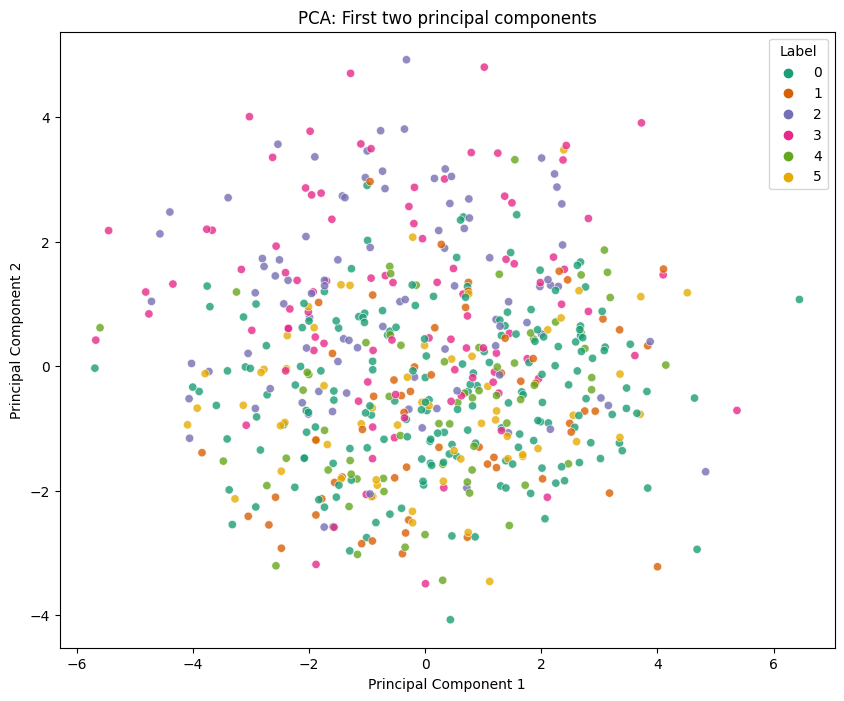

In [24]:
# Visualizing the first two principal components
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Dark2', alpha=0.8)
plt.title('PCA: First two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Label')
plt.show()


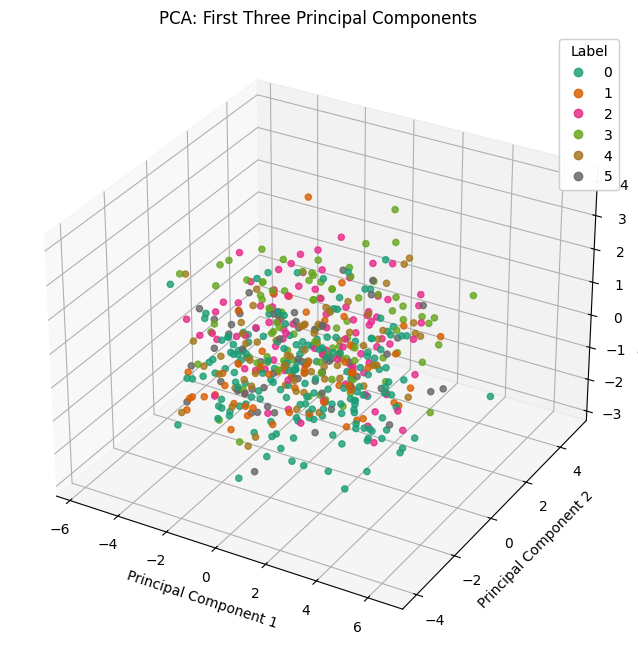

In [25]:
from mpl_toolkits.mplot3d import Axes3D

# Plotting the first three principal components
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='Dark2', alpha=0.8)

# Adding labels
ax.set_title('PCA: First Three Principal Components')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adding a legend
legend1 = ax.legend(*scatter.legend_elements(), title="Label")
ax.add_artist(legend1)

plt.show()


## 7) Data Resampling and Splitting

In [26]:
# Handle class imbalance using SMOTE to balance the dataset by creating synthetic samples of the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_pca, y)

In [27]:
# Split data into training and testing sets (70-30 split)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled)
# Confirming the size of the splits
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)




(781, 5) (335, 5) (781,) (335,)


## 8) Model development
1. ***Hyperparameter Tuning***:

    Define a function tune_hyperparameters which uses GridSearchCV to find the best hyperparameters for a given model based on cross-validated accuracy. Define parameter grids for each model to explore different hyperparameter values.

3. ***Model Initialization***:

    Initialize and tune 3 different models:
    K-Nearest Neighbors, Random Forest, and Gradient Boosting
   using the previously defined hyperparameter grids.
   
5. ***Model Ensembling***:

    Combine the tuned models into a Voting Classifier to create an ensemble model. This Voting Classifier uses a hard voting strategy to make final predictions based on the majority vote from all individual models.


In [28]:
# Function for hyperparameter tuning using GridSearchCV
def tune_hyperparameters(model, params, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=StratifiedKFold(5), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Define hyperparameters for each model
param_grid_knn = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
param_grid_rf = {'n_estimators': [100, 200, 500], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 10, 20]}
param_grid_gb = {'n_estimators': [100, 200, 500], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}

# Initialize models
knn = tune_hyperparameters(KNeighborsClassifier(), param_grid_knn, X_train, y_train)
random_forest = tune_hyperparameters(RandomForestClassifier(), param_grid_rf, X_train, y_train)
gradient_boosting = tune_hyperparameters(GradientBoostingClassifier(), param_grid_gb, X_train, y_train)

# Ensembling using Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('knn', knn),
    ('rf', random_forest),
    ('gb', gradient_boosting)
], voting='hard')

# Prepare a dictionary of all models (individual and ensemble) for subsequent evaluation and comparison.
models = {
    'K-Nearest Neighbors': knn,
    'Random Forest': random_forest,
    'Gradient Boosting': gradient_boosting,
    'Voting Classifier': voting_clf
}

## 9) Model Training and Evaluation

1. ***Model Evaluation***

   A function evaluate_model that trains a given model, makes predictions on both the training and test sets, Additionally, the function plots a confusion matrix to visualize the model's prediction performance.

4. ***Evaluation Loop***:

    Iterate over all models in the models dictionary, using the evaluate_model function to evaluate each model's performance. Store the calculated metrics for each model in the results dictionary.

3. ***Results Conversion***:

    Convert the results dictionary into a pandas DataFrame for easier manipulation and visualization.

4. ***Displaying Results***:

    Print the DataFrame to display the performance metrics for all models in a tabular format.

5. ***Plotting Results***:

    Create a bar plot to visually compare the models' performance metrics. 


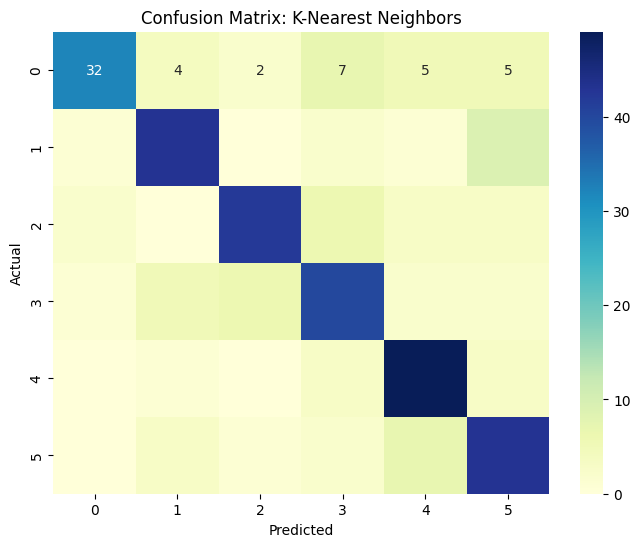

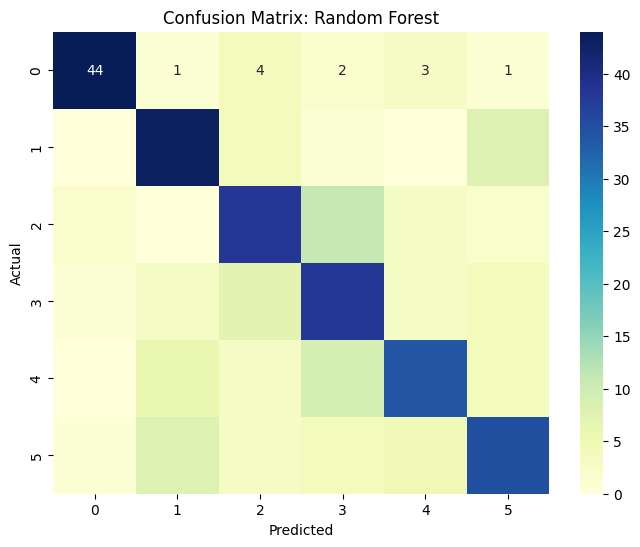

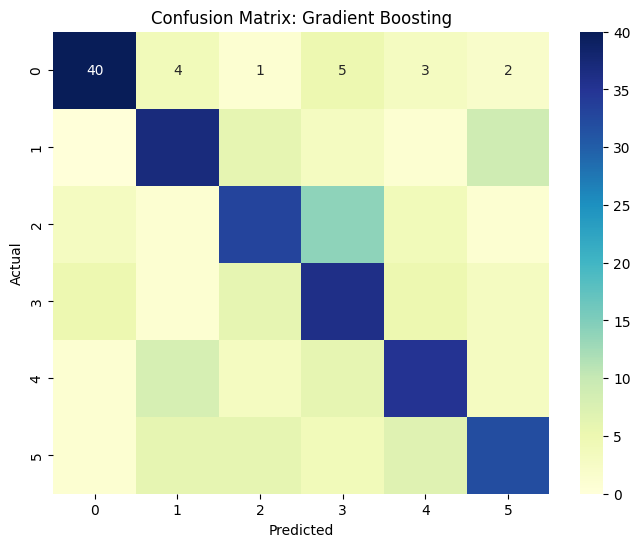

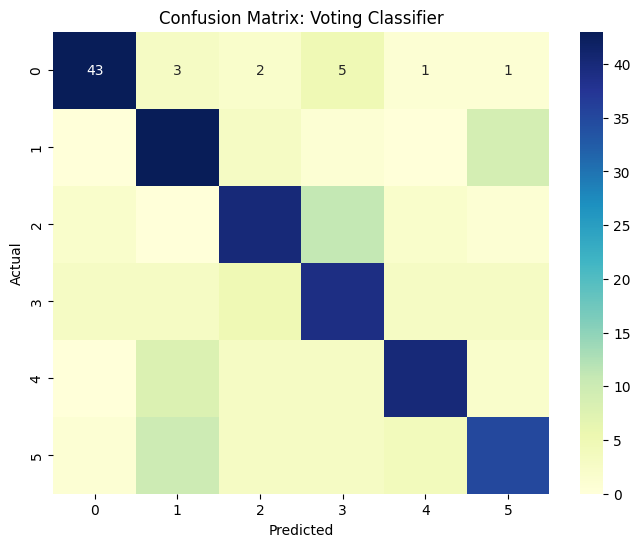

                     Train Accuracy  Test Accuracy
K-Nearest Neighbors         0.99872       0.743284
Random Forest               0.99872       0.692537
Gradient Boosting           0.99872       0.635821
Voting Classifier           0.99872       0.716418


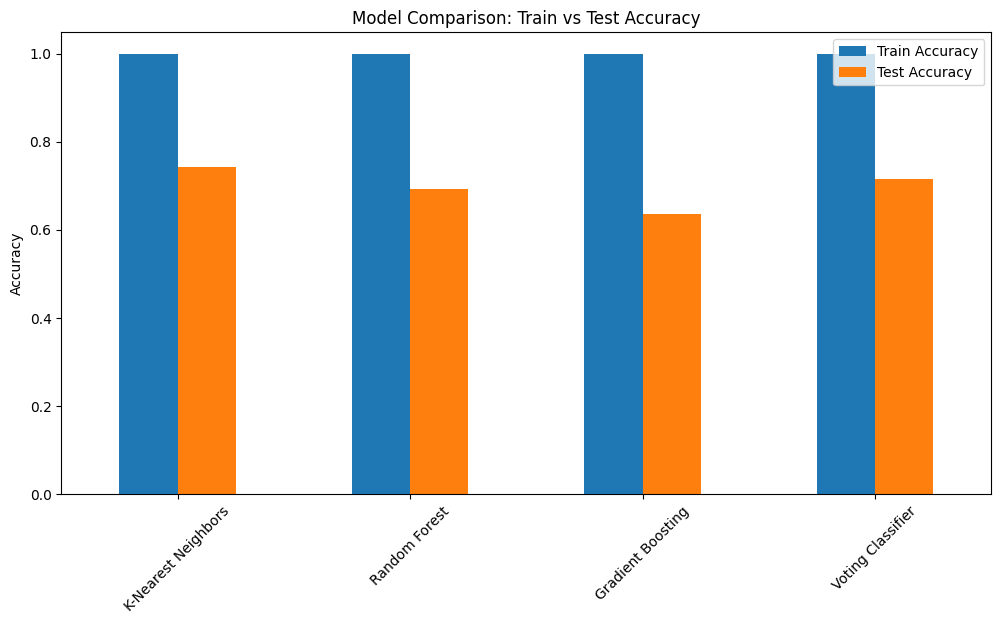

In [29]:
# Function to evaluate models
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
    plt.title(f'Confusion Matrix: {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return train_accuracy, test_accuracy

results = {}
for model_name, model in models.items():
    train_acc, test_acc = evaluate_model(model, X_train, X_test, y_train, y_test, model_name)
    results[model_name] = {'Train Accuracy': train_acc, 'Test Accuracy': test_acc}

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Display the results
print(results_df)

# Plotting the results
results_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Comparison: Train vs Test Accuracy')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# Model Performance Summary

The models compared are:

1. K-Nearest Neighbors (KNN)
2. Random Forest
3. Gradient Boosting
4. Voting Classifier (an ensemble of the above models)


Observations:


- ***K-Nearest Neighbors (KNN)***:

   performs well on both train and test sets, with test accuracy around 0.74

- ***Voting Classifier***:
  
       It combines the predictions of the individual models, achieves the best test accuracy (0.70) and balanced performance across all metrics (F1 score of 0.71, precision of 0.71, and recall of 0.70).


***Conclusion***:

K-Nearest Neighbors (KNN) demonstrates the best overall performance, achieving the highest test accuracy and recall. It effectively handles various classes with fewer misclassifications compared to other models. The Voting Classifier and other ensemble methods provide good performance but do not surpass the accuracy and recall of KNN in this scenario.